Node2Vec representation for clustering journals and as a possible measure of diversity
===


This is a notebook for our paper:

> Zhesi Shen, Fuyou Chen, Liying Yang, Jinshan Wu, Node2Vec representation for clustering journals and as a possible measure of diversity, Journal of Data and Information Science, in press.



In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import pairwise_distances_argmin,cosine_similarity
import networkx as nx
import seaborn as sns
%matplotlib inline

## Node2Vec of journal citation networks

[Node2Vec](https://snap.stanford.edu/node2vec/) is used to embedding the Journal citation network extracted from Journal Citation Report 2018. 
Links with less than 6 citations are removed.

In [ ]:
# load node2vec packages
import numpy as np
import networkx as nx
import node2vec
from gensim.models import Word2Vec
import pandas as pd

The implementation of Node2Vec is based on [link](https://github.com/aditya-grover/node2vec)

In [ ]:
# node2vec embedding
input = './data/jcr.edgelist' #edgelist
output = './data/jcr.emd' # embedding file

dimensions = 32
walk_length = 80
num_walks = 80
window_size = 10
iter = 1     #'Number of epochs in SGD
workers = 8  #'Number of parallel workers. Default is 8.'
p = 1       #'Return hyperparameter. Default is 1.'
q = .5       #'Inout hyperparameter. Default is 1.'
weighted = True #'Boolean specifying (un)weighted. Default is unweighted.')
directed = True #'Graph is (un)directed. Default is undirected.')

def read_graph():
    '''
    Reads the input network in networkx.
    '''

    if weighted:
        G = nx.read_edgelist(input, nodetype=int, data=(('weight',int),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not directed:
        G = G.to_undirected()
    print(len(G))
    return G

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [[str(i) for i in walk] for walk in walks]
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, iter=iter)
    model.wv.save_word2vec_format(output)
    return

'''
Pipeline for representational learning for all nodes in a graph.
'''
print('reading...')
nx_G = read_graph()
G = node2vec.Graph(nx_G, directed, p, q)
print('preprocess...')
G.preprocess_transition_probs()
print('simulate...')
walks = G.simulate_walks(num_walks, walk_length)
print('embedding...')
learn_embeddings(walks)
print('Finished')

## T-SNE for dimension reduction
t-sne is used to reduce the embedded vector to 2d.

In [ ]:
# load packages
from sklearn import manifold
from sklearn.preprocessing import normalize

In [ ]:
# load embedding
df0 = pd.read_csv('./data/jcr.nodelist')
emd = pd.read_csv('./data/jcr.emd',sep=' ',skiprows=[0],header=None,index_col=0)
idx = emd.index
emd = normalize(emd)

In [ ]:
# t-SNE embedding of the journal embedding
print("Computing t-SNE embedding...", end=' ')
tsne = manifold.TSNE(n_components=2, random_state=0, init='pca', perplexity=400.0)
X_tsne = tsne.fit_transform(emd)
print("Finished")

In [ ]:
df_tsne = pd.DataFrame(data=X_tsne)
df_tsne.columns = ['X','Y']
df_tsne['id'] = idx#emd.index
df_tsne = pd.merge(df0,df_pos,on='id')
df_tsne.head(2)

## Pairwise similarity

In [4]:
cos_sim = cosine_similarity(emd)

In [6]:
cos_sim_list = cos_sim.flatten()

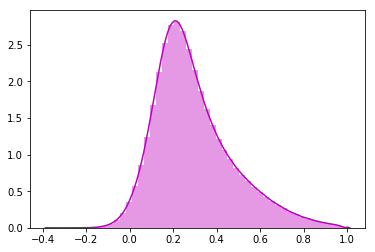

In [7]:
# Figure: pairwise consine similarity
f, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
sns.despine(left=True)
sns.distplot(cos_sim_list, color="m")
plt.xlabel('pairwise cosine similarity')

## Vector Norm, Centrality and Diversity

In [5]:
from sklearn.preprocessing import normalize
df0 = pd.read_csv('./data/jcr.nodelist')
emd = pd.read_csv('./data/jcr.emd',sep=' ',skiprows=[0],header=None,index_col=0)
idx = emd.index
norm_emd,norm = normalize(emd,return_norm=True)

In [6]:
df1 = pd.DataFrame(data=norm)
df1.columns = ['norm']
df1['id'] = idx#emd.index
df = pd.merge(df0,df1,on='id')

df_multi = pd.read_excel('./data/ESIMasterJournalList-102018.xlsx')


In [7]:
from scipy.stats import binned_statistic

In [8]:
df_tf = pd.read_csv('./data/tf.csv')
df_tf.head(2)

,id,tf
0,30,283666
1,56,130972


In [9]:
df = pd.merge(df,df_tf,on='id')
df['log tf'] = np.log10(df['tf'])

df_multi = pd.merge(df_multi,df,left_on='Full Journal Title',right_on='Title')


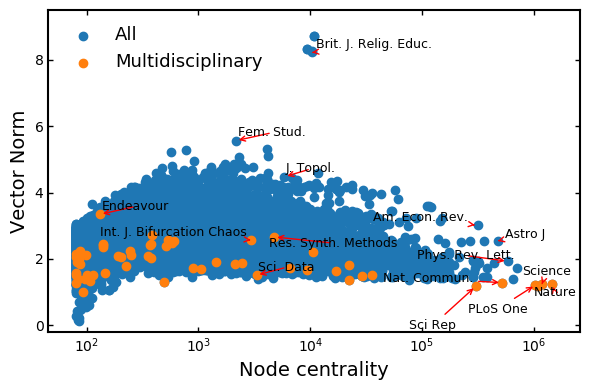

In [10]:
# figure for node centrality vs vector norm
from adjustText import adjust_text

jours = {'Journal of Topology':'J. Topol.','FEMINIST STUDIES':'Fem. Stud.','Scientific Data':'Sci. Data','NATURE':'Nature','SCIENCE':'Science','PLoS One':'PLoS One','Scientific Reports':'Sci Rep',
              'AMERICAN ECONOMIC REVIEW':'Am. Econ. Rev.','PHYSICAL REVIEW LETTERS':'Phys. Rev. Lett.','ASTROPHYSICAL JOURNAL':'Astro J',
        'Nature Communications':'Nat. Commun.','British Journal of Religious Education':'Brit. J. Relig. Educ.',
        'Research Synthesis Methods':'Res. Synth. Methods','INTERNATIONAL JOURNAL OF BIFURCATION AND CHAOS':' Int. J. Bifurcation Chaos',
        'ENDEAVOUR':'Endeavour',
        }
text_jours = []
dfc = df.copy()
dfc.set_index('Title',inplace=True)
for jour in jours:
    #print(jour)
    x = dfc.loc[jour]['log tf']
    y = dfc.loc[jour]['norm']
    t = jours[jour]
    text_jours.append((x,y,t))
    
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=100)
#bin_means, bin_edges, binnumber = binned_statistic(df['log tf'], df['norm'], bins=50, range=(df['log tf'].min(), df['log tf'].max()))
ax.scatter(df['log tf'],df['norm'],label='All')
#plt.plot((bin_edges[:-1]+bin_edges[1:])*0.5,bin_means, 'r-', lw=2)
ax.scatter(df_multi['log tf'],df_multi['norm'],label='Multidisciplinary')

#for x,y,t in text_jours:
#    print(x,y,t)
#    plt.text(x,y,t)
texts = [ax.text(x, y, t,fontsize=9) for x,y,t in text_jours]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

#ax.set_xscale('log')
ax.set_xlabel('Node centrality',fontsize=14)
ax.set_ylabel('Vector Norm',fontsize=14)
ax.set_ylim(-0.2,9.5)
ax.xaxis.set_tick_params(width=1, which='both', direction='in')
ax.yaxis.set_tick_params(width=1, which='both', direction='in')
plt.xticks([2,3,4,5,6],['$10^2$','$10^3$','$10^4$','$10^5$','$10^6$'])


#ax[1,1].spines['right'].set_visible(False)
#ax[1,1].spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.legend(loc='upper left', frameon=False,numpoints=1,fontsize=13)
plt.tight_layout()
#plt.savefig('D:/Data/Map/figure/Fig_vector_norm.pdf', bbox_inches='tight')
#plt.savefig('D:/Data/Map/figure/Fig_vector_norm.eps', bbox_inches='tight')
#plt.savefig('D:/Data/Map/figure/Fig_vector_norm.png', bbox_inches='tight',dpi=300)

## King - Man + Woman = Queen

| Example |           Test 1          |            Test 2           |          Test 3          |
|:-------:|:-------------------------:|:---------------------------:|:------------------------:|
|   King  |     PLoS Comput. Biol.    |      PLoS Comput. Biol.     |    PLoS Comput. Biol.    |
|   Man   |      Nat. Cell Biol.      |       Nat. Cell Biol.       |      Nat. Cell Biol.     |
|  Woman  |      Phys. Rev. Lett.     |         Genome Biol.        |       J. Neurosci.       |
|  Queen  | J. Stat. Mech. Theory Exp |        Bioinformatics       |        NeuroImage        |
|Queen |        Phys. Rev. E       |      BMC Bioinformatics     |       Biol. Cybern.      |
| Queen|  Fluctuation Noise Lett.  |       J. Comput. Biol.      | Front. Comput. Neurosci. |
|Queen |            EPL            |         BioData Min.        |       Cereb.Cortex |
|Queen |      Eur. Phys. J. B      | J. Bioinform. Comput. Biol. |   J. Comput. Neurosci.   |

In [11]:
# load package
import gensim

C:\Users\zhesi\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [13]:
# load model
model = gensim.models.KeyedVectors.load_word2vec_format('./data/jcr.emd', binary=False)
df0 = pd.read_csv('./data/jcr.nodelist')

In [14]:
jour2id = {df0.loc[row]['Title']:str(df0.loc[row]['id']) for row in df0.index}
id2jour = {str(df0.loc[row]['id']):df0.loc[row]['Title'] for row in df0.index}

In [15]:
# test for Phys. Rev. Lett.
sim = model.most_similar(positive=[jour2id['PHYSICAL REVIEW LETTERS'], jour2id['PLoS Computational Biology']], negative=[jour2id['NATURE CELL BIOLOGY']], topn=5)
[(id2jour[i],j) for i,j in sim]

[('JOURNAL OF STATISTICAL MECHANICS-THEORY AND EXPERIMENT',
  0.8744667768478394),
 ('PHYSICAL REVIEW E', 0.8548662662506104),
 ('FLUCTUATION AND NOISE LETTERS', 0.8365941047668457),
 ('EPL', 0.8311533331871033),
 ('EUROPEAN PHYSICAL JOURNAL B', 0.8290320634841919)]

## Compared with other journal classification systems

In [4]:
# load packages
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_mutual_info_score,adjusted_rand_score

### Classification systems


#### Node2Vec at different aggregation levels

In [5]:
# load nodelist
df0 = pd.read_csv('./data/jcr.nodelist')
df0['Title'] = df0['Title'].str.upper()
emd = pd.read_csv('./data/jcr.emd',sep=' ',skiprows=[0],header=None,index_col=0)
idx = emd.index
emd = normalize(emd)

In [9]:
df2_dict = {'id':idx}
for n_clusters in [5,10,15,20,25,30,40,50,60,80,100,120,140,160,180,200,250,300]:
    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")#, affinity="cityblock")#, connectivity=connectivity)
    ward.fit(emd)
    df2_dict[f'cluster-{n_clusters}'] = ward.labels_

df_cluster = pd.DataFrame(data=df2_dict)    


In [128]:
df = pd.merge(df0[['id','Title']],df_cluster,on='id')
df_aa = pd.read_excel('./data/ESIMasterJournalList-102018.xlsx')
df['Title'] = df['Title'].str.upper()
df_aa['Title'] = df_aa['Title'].str.upper()
df = pd.merge(df,df_aa,on='Title')
df.head(2)

,id,Title,cluster-5,cluster-10,cluster-15,cluster-20,cluster-25,cluster-30,cluster-40,cluster-50,...,cluster-80,cluster-100,cluster-120,cluster-140,cluster-160,cluster-180,cluster-200,cluster-250,cluster-300,AbbrTitle
0,0,CA-A CANCER JOURNAL FOR CLINICIANS,1,1,13,13,13,13,13,0,...,38,38,38,38,69,34,34,34,16,CA-CANCER J CLIN
1,1,NEW ENGLAND JOURNAL OF MEDICINE,1,1,5,0,8,3,16,7,...,23,11,56,56,27,27,6,191,191,NEW ENGL J MED


#### JCR

In [8]:
ts = []
ws = []
for row in df0.index:
    t = df0.loc[row,'Title']
    wos = df0.loc[row,'wos']
    wos = wos.strip('/')
    for w in wos.split('/'):
        ts.append(t)
        ws.append(w)

dfwos = pd.DataFrame(data={'Title':ts,'JCR':ws})

In [130]:
dfwos['Title'] = dfwos['Title'].str.upper()
dfjcr = pd.merge(df,dfwos,on='Title')

#### ESI

In [133]:
df_esi = pd.read_excel('./data/ESIMasterJournalList-102018.xlsx')
df_esi['Full title'] = df_esi['Full title'].str.upper()
df_esi['Title20'] = df_esi['Title20'].str.upper()

df_esi.head(2)

,Full title,Title29,Title20,ISSN,EISSN,Category name
0,2D MATERIALS,2D MATER,2D MATER,2053-1583,2053-1583,MATERIALS SCIENCE
1,3 BIOTECH,3 BIOTECH,3 BIOTECH,2190-572X,2190-5738,BIOLOGY & BIOCHEMISTRY


#### Vosviewer by Loet

In [134]:
df_vos = pd.read_excel('./data/loet_journal_level2_level3.xlsx')
df_vos.columns = ['AbbrTitle','aa','level2','level3']
df_vos['AbbrTitle'] = df_vos['AbbrTitle'].str.upper()

# transform string to number
labels = list(df_vos['level3'].unique())
labels = {labels[i]:i for i in range(len(labels))}

df_vos['category'] = df_vos['level3'].apply(lambda x:labels[x])
df_vos.head(2)

,AbbrTitle,aa,level2,level3,category
0,2D MATER,2D Mater,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,0
1,3 BIOTECH,3 Biotech,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,1


In [135]:
dfvos = pd.merge(df,df_vos,on='AbbrTitle')
dfvos.head(2)

,id,Title,cluster-5,cluster-10,cluster-15,cluster-20,cluster-25,cluster-30,cluster-40,cluster-50,...,cluster-160,cluster-180,cluster-200,cluster-250,cluster-300,AbbrTitle,aa,level2,level3,category
0,0,CA-A CANCER JOURNAL FOR CLINICIANS,1,1,13,13,13,13,13,0,...,69,34,34,34,16,CA-CANCER J CLIN,Ca-Cancer J Clin,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,35
1,1,NEW ENGLAND JOURNAL OF MEDICINE,1,1,5,0,8,3,16,7,...,27,27,6,191,191,NEW ENGL J MED,New Engl J Med,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,30


In [136]:
dfvos[dfvos['AbbrTitle']=='PLOS ONE']

,id,Title,cluster-5,cluster-10,cluster-15,cluster-20,cluster-25,cluster-30,cluster-40,cluster-50,...,cluster-160,cluster-180,cluster-200,cluster-250,cluster-300,AbbrTitle,aa,level2,level3,category
2698,2827,PLOS ONE,1,2,10,1,9,4,14,6,...,150,150,150,74,143,PLOS ONE,Plos One,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,17


### comparison

In [139]:
# comparison among journal classification systems
nclusters = [5,10,15,20,25,30,40,50,60,80,100,120,140,160,180,200,250,300]
NMIs_JCR = []
for c in nclusters:
    nmi = adjusted_mutual_info_score(dfjcr[f'cluster-{c}'],dfjcr['JCR'])
    NMIs_JCR.append(nmi)

dfzky = pd.merge(df,df0,on='Title')   
NMIs_ZKY = []
for c in nclusters:
    nmi = adjusted_mutual_info_score(dfzky[f'cluster-{c}'],dfzky['zky'])
    NMIs_ZKY.append(nmi)
    
dfesi = pd.merge(df,df_esi,left_on='Title',right_on='Full title')   
NMIs_ESI = []
for c in nclusters:
    nmi = adjusted_mutual_info_score(dfesi[f'cluster-{c}'],dfesi['Category name'])
    NMIs_ESI.append(nmi)

NMIs_VOS = []
for c in nclusters:
    nmi = adjusted_mutual_info_score(dfvos[f'cluster-{c}'],dfvos['category'])
    NMIs_VOS.append(nmi)

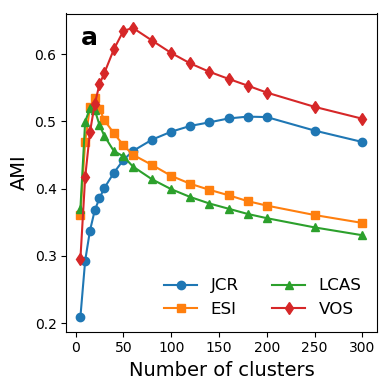

In [140]:
# figure for AMI
plt.figure(figsize=(4,4),dpi=100)
plt.plot(nclusters,NMIs_JCR,'o-',label='JCR')
plt.plot(nclusters,NMIs_ESI,'s-',label='ESI')
plt.plot(nclusters,NMIs_ZKY,'^-',label='LCAS')
plt.plot(nclusters,NMIs_VOS,'d-',label='VOS')

x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(5, y0 + data_height * 0.9, 'a',weight='bold', fontsize=18)

plt.legend(loc='lower right',frameon=False,numpoints=1,fontsize=12,ncol=2)
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('AMI',fontsize=14)
plt.tight_layout()
plt.savefig('D:/Data/Map/figure/clustering_comparing.png',dpi=300)

## Sensitivity analysis of embeeding dimension

In [142]:
# clusters of different dimensions

df_dim = {}
df0 = pd.read_csv(f'D:/Data/Map/graph/g.nodelist')
df0['Title'] = df0['Title'].str.upper()

df_aa = pd.read_csv('D:\\Data\\MultidisciplinaryJournals\\data\\JournalName.csv')
df_aa['Title'] = df_aa['Title'].str.upper()
df_aa['AbbrTitle'] = df_aa['AbbrTitle'].str.upper()


for dim in [8,16,32,64,128]:
    emd = pd.read_csv(f'D:/Data/Map/emb/g{dim}.emd',sep=' ',skiprows=[0],header=None,index_col=0)
    idx = emd.index
    emd = normalize(emd)

    df2_dict = {'id':idx}
    for n_clusters in [5,10,15,20,25,30,40,50,60,80,100,120,140,160,180,200,250,300]:
        ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")#, affinity="cityblock")#, connectivity=connectivity)
        ward.fit(emd)
        df2_dict[f'cluster-{n_clusters}'] = ward.labels_

    df_cluster = pd.DataFrame(data=df2_dict)
    df = pd.merge(df0[['id','Title']],df_cluster,on='id')
    df_dim[dim] = pd.merge(df,df_aa,on='Title')

In [144]:
# comparison 
nmi_dim = {}
for dim in [8,16,32,64,128]:
    dfvos = pd.merge(df_dim[dim],df_vos,on='AbbrTitle')
    # comparison among journal classification systems
    nclusters = [5,10,15,20,25,30,40,50,60,80,100,120,140,160,180,200,250,300]

    NMIs_VOS = []
    for c in nclusters:
        nmi = adjusted_mutual_info_score(dfvos[f'cluster-{c}'],dfvos['category'])

        NMIs_VOS.append(nmi)
    nmi_dim[dim] = NMIs_VOS

nmi_32 = {}
for dim in [8,16,64,128]:
    nclusters = [5,10,15,20,25,30,40,50,60,80,100,120,140,160,180,200,250,300]

    NMIs_VOS = []
    for c in nclusters:
        nmi = adjusted_mutual_info_score(df_dim[32][f'cluster-{c}'],df_dim[dim][f'cluster-{c}'])
        NMIs_VOS.append(nmi)
    nmi_32[dim] = NMIs_VOS

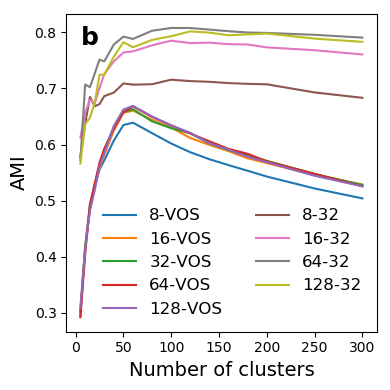

In [145]:
# figure for AMI
plt.figure(figsize=(4,4),dpi=100)
for dim in [8,16,32,64,128]:
    plt.plot(nclusters,nmi_dim[dim],'-',label=f'{dim}-VOS')

for dim in [8,16,64,128]:
    plt.plot(nclusters,nmi_32[dim],'-',label=f'{dim}-32')

    

x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(5, y0 + data_height * 0.9, 'b',weight='bold', fontsize=18)

plt.legend(loc='lower right',frameon=False,numpoints=1,fontsize=12,ncol=2)
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('AMI',fontsize=14)
plt.tight_layout()
plt.savefig('D:/Data/Map/figure/dimension.png',dpi=300)

## Journal diversity

In [16]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import pairwise_distances_argmin,cosine_similarity
import networkx as nx
import seaborn as sns
from indicators import *
from adjustText import adjust_text
import matplotlib.colors as colors


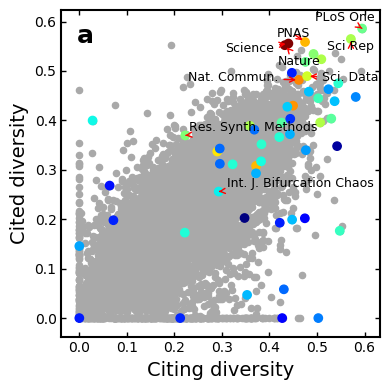

In [20]:
# journal diversity based on node2vec-based simialarity
df0 = pd.read_csv(f'./data/jcr.nodelist')
df_multi = pd.read_excel('./data/ESI.xlsx')


df_citing = pd.read_csv('./data/journal_citing_diversity.csv')
df_cited = pd.read_csv('./data/journal_cited_diversity.csv')


ind = 'rao stirling'

df_div = pd.merge(df_citing[['id',ind]],df_cited[['id',ind]],on='id')
df_div = pd.merge(df_div,df0,on='id')
df_div_multi = pd.merge(df_div,df_multi,right_on='Full Journal Title',left_on='Title')


jours = {'Scientific Data':'Sci. Data','NATURE':'Nature','SCIENCE':'Science','PLoS One':'PLoS One','Scientific Reports':'Sci Rep',
         'PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA':'PNAS',
        'Nature Communications':'Nat. Commun.',
        'Research Synthesis Methods':'Res. Synth. Methods','INTERNATIONAL JOURNAL OF BIFURCATION AND CHAOS':' Int. J. Bifurcation Chaos',
        }

text_jours = []
dfc = df_div.copy()
dfc.set_index('Title',inplace=True)
for jour in jours:
    #print(jour)
    x = dfc.loc[jour][f'{ind}_x']
    y = dfc.loc[jour][f'{ind}_y']
    t = jours[jour]
    text_jours.append((x,y,t))
    
plt.figure(figsize=(4,4),dpi=100)
ax = plt.subplot(111)

plt.scatter(df_div[f'{ind}_x'],df_div[f'{ind}_y'],c='#A9A9A9',s=20)
plt.scatter(df_div_multi[f'{ind}_x'],df_div_multi[f'{ind}_y'],c=np.log(df_div_multi['Impact Factor']),cmap='jet')

texts = [ax.text(x, y, t,fontsize=9) for x,y,t in text_jours]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))


plt.xlabel('Citing diversity',fontsize=14)
plt.ylabel('Cited diversity',fontsize=14)


x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 + data_width * 0.05, y0 + data_height * 0.9, 'a',weight='bold', fontsize=18)

ax.xaxis.set_tick_params(width=1, which='both', direction='in')
ax.yaxis.set_tick_params(width=1, which='both', direction='in')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
#plt.savefig('D:/Data/Map/figure/diversity_journals.png',dpi=300)



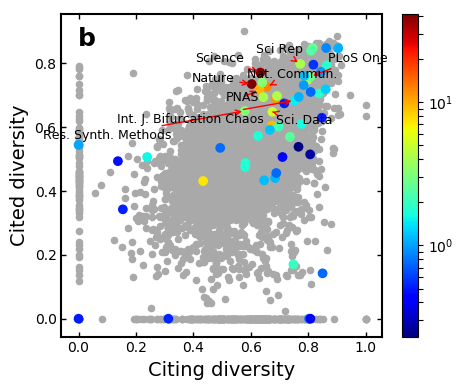

In [21]:
# journal diversity based on citation-based simialarity

df_citing = pd.read_csv('./data/journal_citing_diversity_cos.csv')
df_cited = pd.read_csv('./data/journal_cited_diversity_cos.csv')


ind = 'rao stirling'




df_div = pd.merge(df_citing[['id',ind]],df_cited[['id',ind]],on='id')
df_div = pd.merge(df_div,df0,on='id')
#df_div = df_div[(df_div[f'{ind}_x']>0) & (df_div[f'{ind}_y']>0)]
df_div_multi = pd.merge(df_div,df_multi,right_on='Full Journal Title',left_on='Title')


jours = {'Scientific Data':'Sci. Data','NATURE':'Nature','SCIENCE':'Science','PLoS One':'PLoS One','Scientific Reports':'Sci Rep',
         'PROCEEDINGS OF THE NATIONAL ACADEMY OF SCIENCES OF THE UNITED STATES OF AMERICA':'PNAS',
        'Nature Communications':'Nat. Commun.',
        'Research Synthesis Methods':'Res. Synth. Methods','INTERNATIONAL JOURNAL OF BIFURCATION AND CHAOS':' Int. J. Bifurcation Chaos',
        }

text_jours = []
dfc = df_div.copy()
dfc.set_index('Title',inplace=True)
for jour in jours:
    #print(jour)
    x = dfc.loc[jour][f'{ind}_x']
    y = dfc.loc[jour][f'{ind}_y']
    t = jours[jour]
    text_jours.append((x,y,t))


fig = plt.figure(figsize=(4.82,4),dpi=100)
ax = plt.subplot(111)

plt.scatter(df_div[f'{ind}_x'],df_div[f'{ind}_y'],c='#A9A9A9',s=20)
pos = plt.scatter(df_div_multi[f'{ind}_x'],df_div_multi[f'{ind}_y'],c=df_div_multi['Impact Factor'],cmap='jet',norm=colors.LogNorm())
#plt.scatter(df_div_multi[f'{ind}_x'],df_div_multi[f'{ind}_y'],c='#1C86EE')


texts = [ax.text(x, y, t,fontsize=9) for x,y,t in text_jours]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))


plt.xlabel('Citing diversity',fontsize=14)
plt.ylabel('Cited diversity',fontsize=14)

x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 + data_width * 0.05, y0 + data_height * 0.9, 'b',weight='bold', fontsize=18)

plt.colorbar(pos, ax=ax)

ax.xaxis.set_tick_params(width=1, which='both', direction='in')
ax.yaxis.set_tick_params(width=1, which='both', direction='in')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')


plt.tight_layout()
#plt.savefig('D:/Data/Map/figure/diversity_journals_cos.png',dpi=300)

### Journal diversity vs Journal size

In [108]:
# load nodelist
df0 = pd.read_csv(f'./data/jcr.nodelist')

df_joursize = pd.read_excel('./data/Journal_size.xlsx')


df_citing = pd.read_csv('./data/journal_citing_diversity.csv')
df_cited = pd.read_csv('./data/journal_cited_diversity.csv')

ind = 'rao stirling'

df_div = pd.merge(df_citing[['id',ind]],df_cited[['id',ind]],on='id')
df_div = pd.merge(df_div,df0,on='id')
#df_div = df_div[(df_div[f'{ind}_x']>0) & (df_div[f'{ind}_y']>0)]
df_div_multi = pd.merge(df_div,df_multi,right_on='Full Journal Title',left_on='Title')

In [109]:
df_div['Title'] = df_div['Title'].str.upper()

In [110]:
df_aa = pd.read_csv('./data/JournalName.csv')
df_joursize = pd.merge(df_joursize,df_aa,on='AbbrTitle')

In [111]:
df_joursize['Title'] = df_joursize['Title'].str.upper()

In [112]:
df_div.head(2)

,id,rao stirling_x,rao stirling_y,Title,name,wos,zky,Impact Factor
0,0,0.3051,0.3741,CA-A CANCER JOURNAL FOR CLINICIANS,176885,/ONCOLOGY/,Medicine,244.585007
1,1,0.3972,0.4719,NEW ENGLAND JOURNAL OF MEDICINE,176886,"/MEDICINE, GENERAL & INTERNAL/",Medicine,79.258003


In [113]:
df_div = pd.merge(df_div,df_joursize,on='Title')

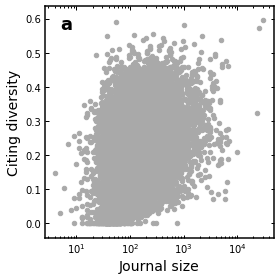

In [119]:
# journal size vs citing diversity
plt.figure(figsize=(4,4))
ax = plt.subplot(111)

plt.scatter(df_div['Size'],df_div[f'{ind}_x'],c='#A9A9A9',s=20)
plt.xscale('log')
plt.xlabel('Journal size',fontsize=14)
plt.ylabel('Citing diversity',fontsize=14)


x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(5, y0 + data_height * 0.9, 'a',weight='bold', fontsize=18)

ax.xaxis.set_tick_params(width=1, which='both', direction='in')
ax.yaxis.set_tick_params(width=1, which='both', direction='in')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('D:/Data/Map/figure/diversity_size1.png',dpi=300)


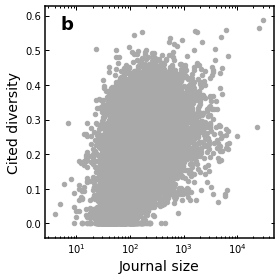

In [120]:
# journal size vs cited diversity
plt.figure(figsize=(4,4))
ax = plt.subplot(111)

plt.scatter(df_div['Size'],df_div[f'{ind}_y'],c='#A9A9A9',s=20)
plt.xscale('log')
plt.xlabel('Journal size',fontsize=14)
plt.ylabel('Cited diversity',fontsize=14)


x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(5, y0 + data_height * 0.9, 'b',weight='bold', fontsize=18)

ax.xaxis.set_tick_params(width=1, which='both', direction='in')
ax.yaxis.set_tick_params(width=1, which='both', direction='in')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['top'].set_linewidth(1.5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
plt.savefig('D:/Data/Map/figure/diversity_size2.png',dpi=300)

## Science Map

### compared with ESI

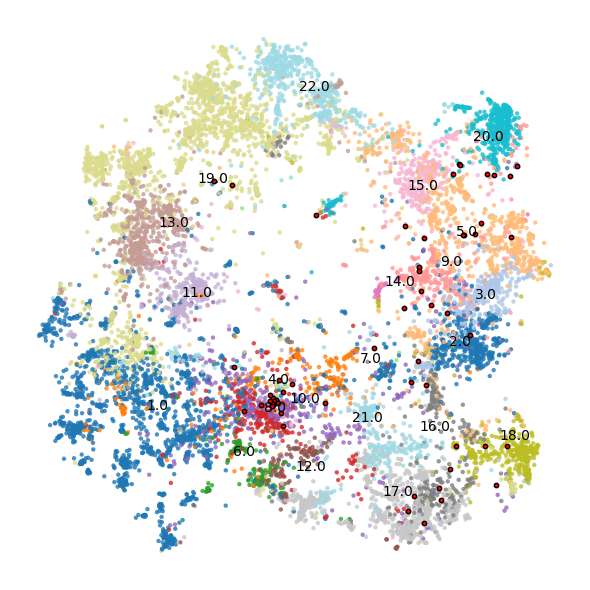

In [27]:
# load layout data
pos = pd.read_excel('./data/jcr_tsne.xlsx')
df_esi = pd.read_excel('D:\\Data\\Map\\data\\ESIMasterJournalList-102018.xlsx')

pos = pd.merge(pos,df_esi,left_on='Title',right_on='Full title')

zky_categories = list(pos['Category name'].unique())
zky_categories = {zky_categories[i]:i+1 for i in range(0,len(zky_categories))}


pos['ESI Cluster'] = pos['Category name'].apply(lambda x:zky_categories[x])


df_multi = pd.read_excel('./data/ESI.xlsx')

df_multi = pd.merge(df_multi,pos,left_on='Full Journal Title',right_on='Title')

vmin,vmax = pos['zky cluster'].min(),pos['zky cluster'].max()



fig,axes = plt.subplots(1,1,figsize=(6,6),dpi=100)
cmap = 'tab20'
col = 1

txt_pos = pos.groupby('ESI Cluster',as_index=False)[['X','Y']].mean()

axes.scatter(pos['X'],pos['Y'],c=pos['ESI Cluster'],cmap=cmap, s=10, linewidth=0,alpha=0.8)
axes.scatter(df_multi['X'],df_multi['Y'],c='r',cmap=cmap,edgecolor='k',linewidth=1,s=10,alpha=1,vmin=vmin,vmax=vmax)

for row in txt_pos.index:
    txt = txt_pos.loc[row]['ESI Cluster']
    x = txt_pos.loc[row]['X']
    y = txt_pos.loc[row]['Y']
    axes.text(x,y,txt)

axes.set_xticks([],[])
axes.set_yticks([],[])


plt.axis('off')
plt.tight_layout()

### compare with VOS

In [24]:
# load layout data
pos = pd.read_excel('./data/jcr_tsne.xlsx')
pos['Title'] = pos['Title'].str.upper()
pos.head(2)

,id,Title,name,wos,zky,Impact Factor,X,Y,cluster,mark,zky cluster
0,0,CA-A CANCER JOURNAL FOR CLINICIANS,176885,/ONCOLOGY/,Medicine,244.585007,-10.386640,-11.662585,3,CA-A CANCER JOURNAL FOR CLINICIANS\nMedicine,0
1,1,NEW ENGLAND JOURNAL OF MEDICINE,176886,"/MEDICINE, GENERAL & INTERNAL/",Medicine,79.258003,-14.535724,-8.469362,3,NEW ENGLAND JOURNAL OF MEDICINE\nMedicine,0


In [149]:
# match abbrtitle
df_aa = pd.read_csv('./data/JournalName.csv')
df_aa['Title'] = df_aa['Title'].str.upper()
pos = pd.merge(pos,df_aa,on='Title')

In [155]:
## load VOS classification system
df_vos = pd.read_excel('./data/loet_journal_level2_level3.xlsx')
df_vos.columns = ['AbbrTitle','aa','level2','level3']
df_vos['AbbrTitle'] = df_vos['AbbrTitle'].str.upper()

# transform string to number
labels = list(df_vos['level2'].unique())
labels = {labels[i]:i for i in range(len(labels))}
df_vos['category'] = df_vos['level2'].apply(lambda x:labels[x])
df_vos = pd.merge(df_vos,pos,on='AbbrTitle')

,AbbrTitle,aa,level2,level3,category
0,2D MATER,2D Mater,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,0
1,3 BIOTECH,3 Biotech,http://www.vosviewer.com/vosviewer.php?map=htt...,http://www.vosviewer.com/vosviewer.php?map=htt...,1


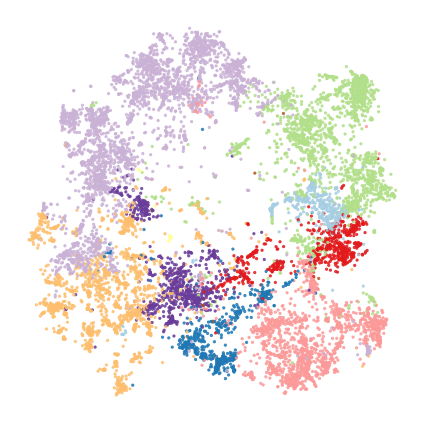

In [157]:
## figure for science map based VOS category
fig,axes = plt.subplots(1,1,figsize=(6,6),dpi=100)

cmap = 'Paired'
col = 0
axes.scatter(df_vos['X'],df_vos['Y'],c=df_vos['category'],cmap=cmap,s=5,alpha=0.8)
axes.set_xticks([],[])
axes.set_yticks([],[])
#axes.set_title('All journals')
plt.axis('off')
plt.tight_layout()
